# FrozenLake 8x8 - QTable

**(This doesn't work yet)**

This environment has 256 states. Because of this E-Greedy Agent takes a lot of episoded to learn the correct policy.
To speed it up in this notebook we use UCB Agent. Based on Upper-Confidence-Bound Action Selection.
For more information check [Sutton book](http://incompleteideas.net/sutton/book/bookdraft2016sep.pdf).

For this tutorial we will use [Frozen Lake 8x8](https://gym.openai.com/envs/FrozenLake8x8-v0).

### Solved
FrozenLake is solved if moving average over window size 100 is >= 0.99

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import wrappers

logging.getLogger('gym').setLevel(logging.WARNING)

## Helper functions

In [22]:
def moving_average(xs, n=100):
    ret = np.cumsum(xs, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def find_index(xs, v):
    """Find index of the first value equal or greater then v"""
    for i in range(len(xs)):
        if xs[i] >= v:
            return i
    return -1

def run_env(agent, env, num_episodes):
    rewards = []
    for episode in range(num_episodes):
        s = env.reset()
        agent.start_episode()
        total_reward = 0
        done = False
        while not done:
            a = agent.choose_action(s, episode)
            s2, reward, done, _ = env.step(a)        
            agent.learn(s, a, reward, s2, done)
            total_reward += reward
            s = s2
        agent.end_episode(s, reward)
        rewards.append(total_reward)

    return rewards

## Explore environment

In [3]:
env = gym.make('FrozenLake8x8-v0')        
states = np.zeros(64)
for i in range(1000):
    s = env.reset()
    action = 3
    s2, reward, done, _ = env.step(action)
    states[s2] += 1
#     print('%d: state=%d, action=%d, end_state=%d' % (i, s, action, s2))
print(states.reshape((8,8)))
env.close()

[[ 683.  317.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]]


## Monte Carlo Agent

MC agent learns from the whole episodes.
It consists of 2 steps:
 * Evaluation - where we trace single episode using current policy $\pi$
 * Improvement - Where we improve our policy to greedy one

In [38]:
class MCAgent:
    
    def __init__(self, num_states, num_actions, alpha=0.1):
        self.qtable = np.zeros([num_states, num_actions])
        self.num_actions = num_actions
        self.gamma = 0.99
        self.alpha = alpha
        
    def start_episode(self):
        """ Initialize (state,action) and received rewards
        """
        self.sa = []
        self.rewards = []
        
    def choose_action(self, state, _):
        """Follow greedy policy"""
        return np.argmax(self.qtable[state,:])
        
    def learn(self, state, action, reward, next_state, done):
        """ Remember (state,action) and reward
            The environment returns rewards 1 if solved and 0 otherwise
            Modify it so we focus on solving in minimal steps
        """
        self.sa.append((state,action))
        if done:
            if reward > 0:
                self.rewards.append(100)
            else:
                self.rewards.append(-100)
        else:
            self.rewards.append(-1)
                
    def end_episode(self, state, reward):
        """ Last state reached. """
        n = len(self.sa)
        g = 0
        for i in reversed(range(n)):
            (s,a) = self.sa[i]
            g += self.rewards[i] + self.gamma**i*g
            self.qtable[s,a] = self.qtable[s,a] - self.alpha*(self.qtable[s,a]-g)
        self.qtable[state,:] = 100 if reward > 0 else -100
        
    def values(self):
        return self.qtable.max(axis=1)        
    
    def policy(self):
        return self.qtable.argmax(axis=1)            

## Train agent

Messing with the rewards:

  * If we don't change reward then the probability of randomly finding solution is very low. 
    And the QTable learning will be very slow. And since there are 256 states, the propagation of
    value is very slow
  * By modifying reward we can try to at least try to not fall into the hole

Found solution 4 times
[[ -3.989e+15  -1.770e+19  -1.885e+12  -1.608e+09  -9.348e+09  -4.807e+10
   -1.815e+13  -1.366e+13]
 [ -5.327e+13  -1.395e+13  -4.726e+14  -1.435e+12  -3.966e+10  -7.215e+09
   -9.254e+11  -6.676e+12]
 [ -4.282e+12  -6.603e+13  -5.610e+11  -1.000e+02  -2.381e+08  -6.674e+08
   -7.423e+10  -1.306e+09]
 [ -3.587e+11  -2.753e+12  -2.127e+08  -1.493e+05  -1.479e+03  -1.000e+02
   -2.156e+07  -2.966e+08]
 [ -3.104e+04  -1.090e+05  -7.013e+04  -1.000e+02  -2.674e+03  -3.359e+04
   -1.145e+05  -3.787e+05]
 [ -2.937e+03  -1.000e+02  -1.000e+02  -1.224e+02  -6.568e+02  -8.662e+02
   -1.000e+02  -9.947e+02]
 [ -2.530e+05  -1.000e+02  -1.719e+01  -1.715e+01  -1.000e+02  -1.816e+02
   -1.000e+02  -3.079e+01]
 [ -2.532e+04  -1.571e+02  -4.509e+01  -1.000e+02   0.000e+00   0.000e+00
    0.000e+00   1.000e+02]]
Policy:
[[2 1 1 1 1 0 0 0]
 [1 1 3 1 0 0 1 3]
 [1 3 1 0 1 0 2 1]
 [1 2 3 3 2 0 0 0]
 [1 1 1 0 0 0 2 3]
 [3 0 0 3 0 3 0 1]
 [3 0 3 2 0 2 0 1]
 [3 3 3 0 1 1 0 0]]


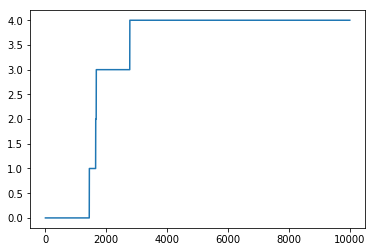

In [39]:
# Environment
env = gym.make('FrozenLake8x8-v0')
# Agent
agent = MCAgent(env.observation_space.n, env.action_space.n, 0.09)
rewards = []
total_rewards = 0
for episode in range(int(1e4)):
    s = env.reset()
    agent.start_episode()
    done = False
    while not done:
        a = agent.choose_action(s, episode)
        s2, reward, done, _ = env.step(a)   
        agent.learn(s, a, reward, s2, done)
        s = s2
    agent.end_episode(s, reward)
    total_rewards += reward
    rewards.append(total_rewards)
    
print('Found solution %d times' % total_rewards)        
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
print(agent.values().reshape(8,8))
print("Policy:")
print(agent.policy().reshape(8,8))
env.close()    
plt.plot(rewards)

Max score: 0.030000
Not solved


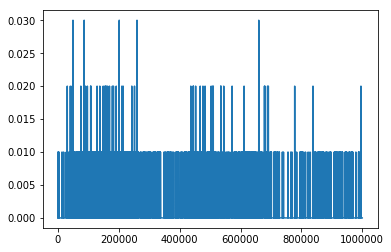

Max Q value:
[[-111.464 -112.954 -111.585 -110.757 -109.983 -107.542 -110.702 -112.72 ]
 [-110.282 -109.989 -107.946 -109.968 -108.423 -106.114 -107.876 -107.674]
 [-107.01  -105.784 -103.678 -100.    -101.282 -101.393 -102.876 -100.709]
 [-105.303 -103.824 -102.631 -100.397 -101.019 -100.    -100.024  -99.672]
 [-102.657 -101.422 -100.519 -100.    -103.448 -100.84  -100.07  -100.201]
 [-102.586 -100.    -100.    -100.761 -102.283  -89.787 -100.     -70.173]
 [-102.42  -100.    -100.629 -100.421 -100.     -63.984 -100.      -5.778]
 [-102.873 -100.986 -101.146 -100.     -35.472  -24.108   70.417  100.   ]]
Policy:
[[1 2 0 1 3 0 2 1]
 [2 1 1 0 2 1 2 2]
 [1 1 1 0 1 1 1 1]
 [2 1 1 2 3 0 1 1]
 [1 1 1 0 3 2 1 1]
 [1 0 0 0 2 0 0 0]
 [2 0 3 1 0 1 0 1]
 [2 2 3 0 2 2 1 0]]


In [26]:
# Learning parameters
num_episodes = int(1e6)
solved_score = 0.99
# Environment
env = gym.make('FrozenLake8x8-v0')
# Agent
agent = MCAgent(env.observation_space.n, env.action_space.n)
# run simulation
rewards = run_env(agent, env, num_episodes)
env.close()
# Show summary
averaged_rewards = moving_average(rewards)    
idx = find_index(averaged_rewards, solved_score)
print('Max score: %f' % np.max(averaged_rewards))
if idx >= 0:
    print('Solved after {} episodes'.format(idx+1))
else:
    print('Not solved')

plt.plot(averaged_rewards)
plt.show()
print("Max Q value:")
print(agent.values().reshape(8,8))
print("Policy:")
print(agent.policy().reshape(8,8))